# Tanzania Water Wells Project

*This is the notebook where I do __Modelling__.* For EDA go to [this notebook](http://localhost:8888/notebooks/Code/Water_wells%20EDA.ipynb).

# 1. Problem Undersanding

<img src="../Images/clean-21479_1280.jpg">

## Business Problem

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, some are functional, but some are in need of repair while others have failed altogether.

The Government of Tanzania is interested in:


> 1) Finding out the waterpoints in need of repairs and those that have completely failed.

> 2) Identifying patterns in waterpoints that don't function as desired.

This can be done by building a classifier that takes in the attributes of a waterpoint and determines whether it is functional, functional-needing-repairs or non-functional. 

Also in the case where a waterpoint is about to be built, feeding in the attributes being considered for the waterpoint to the model would predict whether it will be functional or otherwise which would in building more functional waterpoints for the people of Tanzania.

By being able to build a good classifier, the government can be able to:

> 1) Easily determine waterpoints that are in need of repairs and those that have completely ceased functioning.

> 2) Identify patterns in non-functional waterpoints and guide against them when building wells in future.

The effects of such kind of a classifier would greatly help in improving the living standards of the people of Tanzania by increasing the number of functional waterpoints in the country. This in turn would help raise the living standards and health of the people by making it easy for them to access clean and safe water.

## Data Summary

The data that I am using is from [this site](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/). I have done some cleaning on it in the [EDA notebook](http://localhost:8888/notebooks/Code/Water_wells%20EDA.ipynb). It now has __57,336__ records from the original __59,400__ records. The information has been collected from the year 2002 October to 2013 December. 

Each record represents a __waterpoint__. 


The __features__ are:

    1. amount_tsh - Total Static Head (amount water available to waterpoint)
    2. gps_height - Altitude of the well
    3. longitude - GPS coordinate
    4. latitude - GPS coordinate
    5. population - Population around the well
    6. extraction_class - The kind of extraction the waterpoint uses
    7. management_group - How the waterpoint is managed
    8. payment_type - What the water costs
    9. quality_group - The quality of the water
    10. quantity_group - The quantity of water
    11. source_class - The source of the water
    12. type_group - The kind of waterpoint
    13. public_meeting - True/False
    14. scheme_management - Who operates the waterpoint
    15. permit - If the waterpoint is permitted
    16. region_code - Geographic location (coded)
    17. age - The age of a well at the time it was recorded


The __target feature__ is `status_group` and it consists of the following categories:

    1. functional - The well is operational and there are no repairs needed
    2. functional needs repair - The well is operational, but needs repairs
    3. non functional - The well is not operational

# 2. Loading the Dataset

## 2.1. Importing Libraries

In [67]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from custom_functions import drop_cols, sorted_series, histPlot, min_max
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, precision_score, confusion_matrix, make_scorer, accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier


In [2]:
## ALL functions


## 2.2. Loading the dataset

In [3]:
# the dataset is called Cleaned_data
df = pd.read_csv('/home/nick/Documents/Flatiron/Phase 3/Water_wells_Project/Data/Cleaned_data.csv', index_col='Unnamed: 0')

# Print the shape
print(df.shape)

# Display the first 5 records
df.head()

(57336, 18)


,amount_tsh,gps_height,longitude,latitude,population,extraction_class,management_group,payment_type,quality_group,quantity_group,source_class,type_group,status_group,public_meeting,scheme_management,permit,region_code,age
0,6000.0,1390,34.938093,-9.856322,109,gravity,user-group,annually,good,enough,groundwater,communal standpipe,functional,True,VWC,False,4,12
1,0.0,1399,34.698766,-2.147466,280,gravity,user-group,never pay,good,insufficient,surface,communal standpipe,functional,True,Other,True,13,3
2,25.0,686,37.460664,-3.821329,250,gravity,user-group,per bucket,good,enough,surface,communal standpipe,functional,True,VWC,True,26,4
3,0.0,263,38.486161,-11.155298,58,submersible,user-group,never pay,good,dry,groundwater,communal standpipe,non functional,True,VWC,True,17,27
4,0.0,0,31.130847,-1.825359,0,gravity,other,never pay,good,seasonal,surface,communal standpipe,functional,True,VWC,True,5,11


In [4]:
# check the datatypes
print(df.dtypes.value_counts())

df.dtypes

object     9
int64      4
float64    3
bool       2
dtype: int64


amount_tsh           float64
gps_height             int64
longitude            float64
latitude             float64
population             int64
extraction_class      object
management_group      object
payment_type          object
quality_group         object
quantity_group        object
source_class          object
type_group            object
status_group          object
public_meeting          bool
scheme_management     object
permit                  bool
region_code            int64
age                    int64
dtype: object

## 2.3. Train test split

The target column is `status_group`. I am going to split the data into train and test parts with a ratio of 75:25 respectively.

In [5]:
# separate the data into target and features
features = drop_cols(df, 'status_group')
target = df['status_group']

# # make the target a binary class
# target = target.replace({'functional needs repair': 'non functional'})

In [6]:
# perform the split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

# print out the shapes
print(f"""
X:  train = {X_train.shape}
    test = {X_test.shape}
    
y:  train = {y_train.shape}
    test = {y_test.shape}
""")


X:  train = (40135, 17)
    test = (17201, 17)
    
y:  train = (40135,)
    test = (17201,)



# 3. Data Preprocessing 

I am going to apply either scaling, normalization or standardization to the numeric columns that require me to. Then proceed to do some encoding on the categorical columns of the data.

## 3.1. Numerical columns

Dealing with numerical columns.

I am going to exclude `region_code`, `latitude` and `longitude` from all operations because they are features explaining location and should not be edited.

In [7]:
# create a dataframe of only numeric data
# train data
numeric_df_train = X_train.drop(columns=['region_code', 'latitude', 'longitude']).select_dtypes(include='number').copy()
# test data
numeric_df_test = X_test.drop(columns=['region_code', 'latitude', 'longitude']).select_dtypes(include='number').copy()

# make a list of the columns
numeric_columns = numeric_df_train.columns
print(numeric_columns)

# check the min and max for all columns
for column in numeric_columns:
    print(f'{column}: {min_max(numeric_df_train, column)}')

Index(['amount_tsh', 'gps_height', 'population', 'age'], dtype='object')
amount_tsh: (0.0, 9000.0)
gps_height: (-90, 2770)
population: (0, 9500)
age: (0, 53)


### 3.1.1. MinMax scaling 

Making the scale uniform for the columns to have the same weights.

In [8]:
# Instantiate the transformer
# increasing the scaling so as to give a wider margin for the model to differenciate values
minmax_transfomer = MinMaxScaler(feature_range=(0, 100))
# fit the data
minmax_transfomer.fit(numeric_df_train)

# transfrom training data
minmax_train = minmax_transfomer.transform(numeric_df_train)
minmax_train_df = pd.DataFrame(minmax_train, columns=numeric_columns, index=numeric_df_train.index)
# transform test data
minmax_test = minmax_transfomer.transform(numeric_df_test)
minmax_test_df = pd.DataFrame(minmax_test, columns=numeric_columns, index=numeric_df_test.index)

# display the transformed data
minmax_train_df.head()

,amount_tsh,gps_height,population,age
26554,0.0,54.405594,0.010526,81.132075
36398,0.0,65.769231,3.789474,5.660377
47605,0.0,55.839161,1.578947,20.754717
50087,0.0,3.146853,0.000000,20.754717
11021,0.0,3.146853,0.000000,20.754717


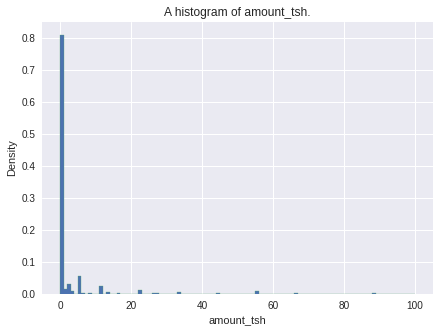

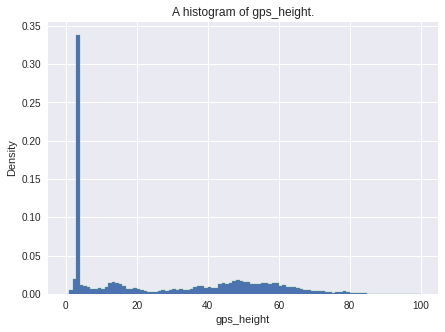

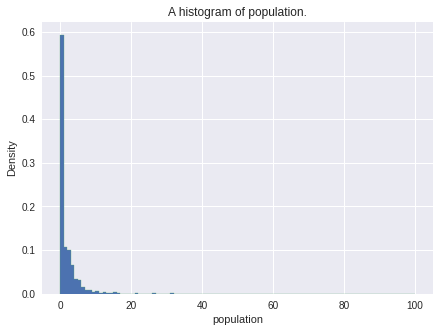

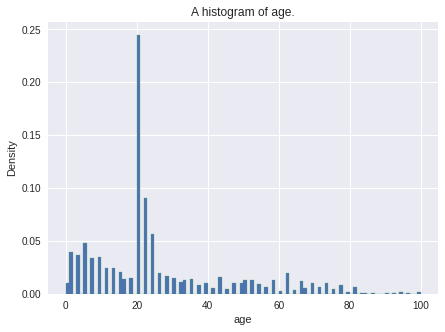

In [9]:
# check the distibution
for column in numeric_columns:
    plt.style.use('seaborn')
    histPlot(minmax_train_df, column)

#### Dropping and replacement

Dropping the original features from the data and replacing them with the scaled features.


In [10]:
# dropping them from test and train
X_train = drop_cols(X_train, numeric_columns)
X_test = drop_cols(X_test, numeric_columns)

# replacing them
X_train = pd.concat([X_train, minmax_train_df], axis=1)
X_test = pd.concat([X_test, minmax_test_df], axis=1)

X_train.head()

,longitude,latitude,extraction_class,management_group,payment_type,quality_group,quantity_group,source_class,type_group,public_meeting,scheme_management,permit,region_code,amount_tsh,gps_height,population,age
26554,37.553240,-3.273088,gravity,user-group,monthly,good,insufficient,groundwater,communal standpipe,True,WUA,True,9,0.0,54.405594,0.010526,81.132075
36398,35.541263,-8.118425,handpump,user-group,never pay,good,enough,groundwater,hand pump,True,VWC,True,4,0.0,65.769231,3.789474,5.660377
47605,36.640383,-3.313886,gravity,user-group,never pay,good,insufficient,groundwater,communal standpipe,True,VWC,True,1,0.0,55.839161,1.578947,20.754717
50087,35.661258,-6.368428,motorpump,user-group,per bucket,good,enough,groundwater,communal standpipe,True,VWC,True,3,0.0,3.146853,0.000000,20.754717
11021,33.808783,-9.577177,gravity,user-group,never pay,good,dry,groundwater,communal standpipe,True,VWC,True,14,0.0,3.146853,0.000000,20.754717


### 3.2. Categorical(object) columns

Here I am dealing with all columns with string-like records.

Considering that all of them are categorical, I am going to encode the categories per column with numbers. I do this in order to prevent curse of dimensionality that would most likely occur if I one hot encode instead.

In [11]:
# create a dataframe of only object data
# train data
obj_df_train = X_train.select_dtypes(include='object').copy()
# test data
obj_df_test = X_test.select_dtypes(include='object').copy()

# make a list of the columns
obj_columns = obj_df_train.columns
print(obj_columns)


Index(['extraction_class', 'management_group', 'payment_type', 'quality_group',
       'quantity_group', 'source_class', 'type_group', 'scheme_management'],
      dtype='object')


> `permit` and `public_meeting` are not in the datasets created above because they are of boolean dtype.

#### 3.2.1. One Hot Encoding

I am only encoding two columns here, permit and public meeting.

In [12]:
# the target columns for this are permit and public meeting
train_ohe = X_train[['permit', 'public_meeting']]
test_ohe = X_test[['permit', 'public_meeting']]

# instantiate the encoder
ohe_encoder = OneHotEncoder(drop='first', sparse=False).fit(train_ohe)

# transform the data
train_OHE = ohe_encoder.transform(train_ohe)
test_OHE = ohe_encoder.transform(test_ohe)

# replace the originals with the new ones
X_train[['permit', 'public_meeting']] = train_OHE
X_test[['permit', 'public_meeting']] = test_OHE


In [13]:
# Checking to see whether it worked
X_train.head()

,longitude,latitude,extraction_class,management_group,payment_type,quality_group,quantity_group,source_class,type_group,public_meeting,scheme_management,permit,region_code,amount_tsh,gps_height,population,age
26554,37.553240,-3.273088,gravity,user-group,monthly,good,insufficient,groundwater,communal standpipe,1.0,WUA,1.0,9,0.0,54.405594,0.010526,81.132075
36398,35.541263,-8.118425,handpump,user-group,never pay,good,enough,groundwater,hand pump,1.0,VWC,1.0,4,0.0,65.769231,3.789474,5.660377
47605,36.640383,-3.313886,gravity,user-group,never pay,good,insufficient,groundwater,communal standpipe,1.0,VWC,1.0,1,0.0,55.839161,1.578947,20.754717
50087,35.661258,-6.368428,motorpump,user-group,per bucket,good,enough,groundwater,communal standpipe,1.0,VWC,1.0,3,0.0,3.146853,0.000000,20.754717
11021,33.808783,-9.577177,gravity,user-group,never pay,good,dry,groundwater,communal standpipe,1.0,VWC,1.0,14,0.0,3.146853,0.000000,20.754717


#### 3.2.2.  Label Encoding 

This involves all columns in the dataframes created that should contain features that are of object datatypes.

In [14]:
for column in obj_columns:
    # instantiate and fit the encoder 
    le_encoder = LabelEncoder().fit(obj_df_train[column])

    # transform the data
    x_train_le = le_encoder.transform(obj_df_train[column])
    x_test_le = le_encoder.transform(obj_df_test[column])
    
    # replace encoded data with non encoded data
    obj_df_train[column] = x_train_le
    obj_df_test[column] = x_test_le

    
## put back the encoded data in the original dataframes
# drop the object type columns first
X_train = drop_cols(X_train, obj_columns)
X_test = drop_cols(X_test, obj_columns)
# Concatenate the transformed dataframe and the original
X_train_enc = pd.concat([X_train, obj_df_train], axis=1)
X_test_enc = pd.concat([X_test, obj_df_test], axis=1)


# Checking to see whether it worked
X_train_enc.head()

,longitude,latitude,public_meeting,permit,region_code,amount_tsh,gps_height,population,age,extraction_class,management_group,payment_type,quality_group,quantity_group,source_class,type_group,scheme_management
26554,37.553240,-3.273088,1.0,1.0,9,0.0,54.405594,0.010526,81.132075,0,4,1,2,2,0,1,8
36398,35.541263,-8.118425,1.0,1.0,4,0.0,65.769231,3.789474,5.660377,1,4,2,2,1,0,3,7
47605,36.640383,-3.313886,1.0,1.0,1,0.0,55.839161,1.578947,20.754717,0,4,2,2,2,0,1,7
50087,35.661258,-6.368428,1.0,1.0,3,0.0,3.146853,0.000000,20.754717,2,4,5,2,1,0,1,7
11021,33.808783,-9.577177,1.0,1.0,14,0.0,3.146853,0.000000,20.754717,0,4,2,2,0,0,1,7


## 3.3. Encoding Target column


In [15]:
# Instantiate the encoder
le_encode = LabelEncoder().fit(y_train)

# transform the data
y_train_le = le_encode.transform(y_train)
y_test_le = le_encode.transform(y_test)

# put back the encoded data in the original dataframes
y_train_enc = pd.Series(y_train_le, index=y_train.index, name='status_group')
y_test_enc = pd.Series(y_test_le, index=y_test.index, name='status_group')

# Checking to see whether it worked
y_train.head(), y_train_enc.head()

(26554    functional needs repair
 36398                 functional
 47605                 functional
 50087                 functional
 11021             non functional
 Name: status_group, dtype: object,
 26554    1
 36398    0
 47605    0
 50087    0
 11021    2
 Name: status_group, dtype: int64)

# 4. Modelling

The main focus for this project is in identifying non-functional waterpoints and pointing out whether a waterpoint construction in progress would result in a functional or non-functional one. The line in between these classes is those waterpoints that are still functional but in need of repairs.

Therefore, the accuracy metric score of my model is very important in evaluating it's perfomance.

I am going to build two kinds of classifiers:

1. Decision Tree classifier
2. K-nearest neighbor classifier

I am also using the random forest ensemble method with decision tree classifiers

## 4.1. Baseline models

### 4.1.1. Decision Tree classifier

In [16]:
# Instantiate the baseline model
tree_baselineModel = DecisionTreeClassifier(random_state=42)
# Fit the model
tree_baselineModel.fit(X_train_enc, y_train_enc)

# perform cross validation with train data
tree_baselineModel_logLoss_train = -(cross_val_score(tree_baselineModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())

# check the test logloss
treeBaseline_preds = tree_baselineModel.predict(X_test_enc)
treeBaseline_probs = tree_baselineModel.predict_proba(X_test_enc)
tree_baselineModel_logLoss_test = log_loss(y_test_enc, treeBaseline_probs)

# compare model scores on test data and train data
print('Train:', tree_baselineModel_logLoss_train, ',Test:', tree_baselineModel_logLoss_test)

Train: 9.128871633317276 ,Test: 8.746637403420204


In [71]:
# precision score
treeBaseline_prec = precision_score(y_test_enc, treeBaseline_preds, average='micro')
print('Precision:', treeBaseline_prec)
print()

# accuracy score
treeBaseline_acc = accuracy_score(y_test_enc, treeBaseline_preds)
print('Accuracy:', treeBaseline_acc)
print()

# recall score
treeBaseline_rec = recall_score(y_test_enc, treeBaseline_preds, average='micro')
print('Recall:', treeBaseline_rec)

Precision: 0.7467589093657345

Accuracy: 0.7467589093657345

Recall: 0.7467589093657345


> __Note:__ For this problem, Accuracy, recall and prediction scores prduce the same values and can thus be used __interchangeably__.

> I am going to use accuracy score henceforth.


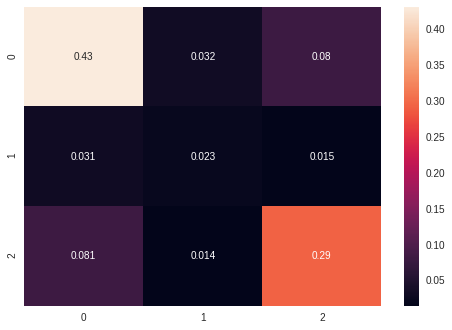

In [18]:
# make a confusion matrix to view accuracy
tree_baselineModel_conf = confusion_matrix(y_test_enc, treeBaseline_preds)

# plot the matrix
sns.heatmap(tree_baselineModel_conf/np.sum(tree_baselineModel_conf), annot=True);

### 4.1.2. K-nearest Neighbor classifier

In [19]:
# Creating the model
# n_jobs dictates the number of processors that the classifier uses
# I am setting it to -1 for faster runtime
knn_baselineModel = KNeighborsClassifier(n_jobs=-1)
knn_baselineModel.fit(X_train_enc, y_train_enc)

# Perform cross-validation
knn_baselineModel_logLoss_train = -(cross_val_score(knn_baselineModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())

# Check test scoring
knnBaseline_preds = knn_baselineModel.predict(X_test_enc)
knnBaseline_probs = knn_baselineModel.predict_proba(X_test_enc)
knn_baselineModel_logLoss_test = log_loss(y_test_enc, knnBaseline_probs)

# compare model scores on test data and train data
print('Train:', knn_baselineModel_logLoss_train, ',Test:', knn_baselineModel_logLoss_test)

Train: 2.728314216524497 ,Test: 2.6631151307125154


In [20]:
# accuracy score
knnBaseline_acc = accuracy_score(y_test_enc, knnBaseline_preds)
print(knnBaseline_acc)

0.7469333178303587


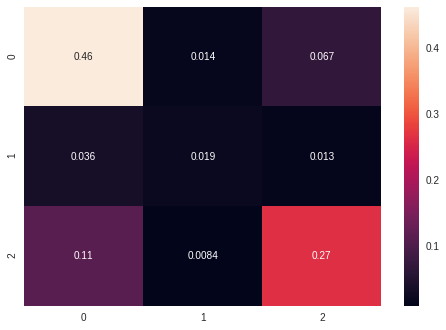

In [21]:
# make a confusion matrix to view accuracy
knn_baselineModel_conf = confusion_matrix(y_test_enc, knnBaseline_preds)

# plot the matrix
sns.heatmap(knn_baselineModel_conf/np.sum(knn_baselineModel_conf), annot=True);

### Conclusions:

The KNN classifier performs slightly better than the tree classifier as shown by the accuracy of the models. 

The model scores are:

    Tree Model = 0.7467
    KNN Model = 0.7469

However, there is a class imbalance (though not dramatic) which could be a factor affecting the performance of the model.I need to look into this.

Then I will use SMOTE to balance out the classes.

In [22]:
# checking the target class proportions
print(f"""Train:
{y_train_enc.value_counts(normalize=True)}

Test:
{y_test_enc.value_counts(normalize=True)}
""")

Train:
0    0.543715
2    0.387891
1    0.068394
Name: status_group, dtype: float64

Test:
0    0.543689
2    0.387884
1    0.068426
Name: status_group, dtype: float64



## 4.2. Resampling with SMOTE

Applying SMOTE to the training data to balance out the class distribution in `status_group`, the target variable.

This should help increase the model's performance.

In [23]:
# Instantiate SMOTE for train data
sm_train = SMOTE(random_state=42, sampling_strategy='auto')

# Transform train data
X_train_res, y_train_res = sm_train.fit_resample(X_train_enc, y_train_enc)

# checking the new proportions for the target class
print(f"""Train:

{y_train_res.value_counts(normalize=True)}
""")

Train:

2    0.333333
1    0.333333
0    0.333333
Name: status_group, dtype: float64



In [24]:
# Cheking if the indexes are the same 
# thus verifying Resampling has been done correctly
result = X_train_res.index == y_train_res.index

# asserting the indexes are same
print(f'The assumption that the indexes of X and y data are the same is {result.all()}')
print()

# Checking the number of rows introduced
new_rows = X_train_res.shape[0] - X_train_enc.shape[0]
print(f'The number of rows has increased by {new_rows} after Resampling!')

The assumption that the indexes of X and y data are the same is True

The number of rows has increased by 25331 after Resampling!


## 4.3. Baseline models Repeat after SMOTE

The models in this section are fitted with data that has been oversampled.

### 4.2.1. Decision Tree classifier

In [25]:
# Instantiate the baseline model
tree_baselineModel_2 = DecisionTreeClassifier(random_state=42)
# Fit the model
tree_baselineModel_2.fit(X_train_res, y_train_res)

# perform cross validation with train data
tree_baselineModel_2_logLoss_train = -(cross_val_score(tree_baselineModel_2, X_train_res, y_train_res, scoring='neg_log_loss', cv=3).mean())

# check the test logloss
treeBaseline_2_preds = tree_baselineModel_2.predict(X_test_enc)
treeBaseline_2_probs = tree_baselineModel_2.predict_proba(X_test_enc)
tree_baselineModel_2_logLoss_test = log_loss(y_test_enc, treeBaseline_2_probs)

# compare model scores on test data and train data
print('Train:', tree_baselineModel_2_logLoss_train, ',Test:', tree_baselineModel_2_logLoss_test)

Train: 7.211537814163599 ,Test: 9.134172072580007


In [26]:
# accuracy score
treeBaseline_2_acc = accuracy_score(y_test_enc, treeBaseline_2_preds)
print(treeBaseline_2_acc)

0.7355386314749143


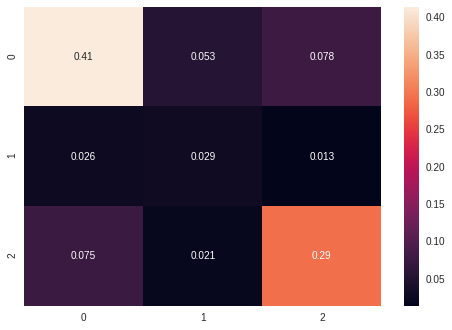

In [27]:
# make a confusion matrix to view accuracy
tree_baselineModel_2_conf = confusion_matrix(y_test_enc, treeBaseline_2_preds)

# plot the matrix
sns.heatmap(tree_baselineModel_2_conf/np.sum(tree_baselineModel_2_conf), annot=True);

### 4.2.2. K-nearest Neighbor classifier

In [28]:
# Creating the model
knn_baselineModel_2 = KNeighborsClassifier(n_jobs=-1)
knn_baselineModel_2.fit(X_train_res, y_train_res)

# Perform cross-validation
knn_baselineModel_2_logLoss_train = -(cross_val_score(knn_baselineModel_2, X_train_res, y_train_res, scoring='neg_log_loss', cv=3).mean())

# Check test scoring
knnBaseline_2_preds = knn_baselineModel_2.predict(X_test_enc)
knnBaseline_2_probs = knn_baselineModel_2.predict_proba(X_test_enc)
knn_baselineModel_2_logLoss_test = log_loss(y_test_enc, knnBaseline_2_probs)

# compare model scores on test data and train data
print('Train:', knn_baselineModel_2_logLoss_train, ',Test:', knn_baselineModel_2_logLoss_test)

Train: 2.106094892534855 ,Test: 3.9065525187384846


In [29]:
# accuracy score
knnBaseline_2_acc = accuracy_score(y_test_enc, knnBaseline_2_preds)
print(knnBaseline_2_acc)

0.6971106331027266


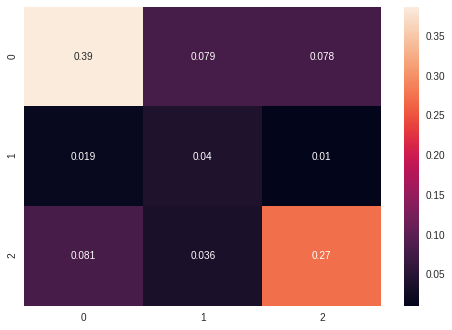

In [30]:
# make a confusion matrix to view accuracy
knn_baselineModel_2_conf = confusion_matrix(y_test_enc, knnBaseline_2_preds)

# plot the matrix
sns.heatmap(knn_baselineModel_2_conf/np.sum(knn_baselineModel_2_conf), annot=True);

### Conclusions:

The perfomance of the models with the __resampled__ data worse for both kinds of models. ALthough for the tree classifier it's not as bad as for the KNN classifier.

Model scores are:

    Tree Model = 0.7355
    KNN Model = 0.6971
    
Seeing the decrease in precision, I am not going to use the resampled data when modelling.

## 4.4. Model Tuning Hyperparameters

Here I am tuning my models to find the best hyperparameter values

### 4.4.1. Decision Tree Classifier

#### 4.4.1.1. tree Depth

Tree depth is a great determiner of the performance of a tree classifier as it directly affects overfitting and underfitting. The deeper a tree the more likely it is to overfit.

However, the baseline model is neither underfitting nor overfitting, I am just looking for the depth that minimizes loss.

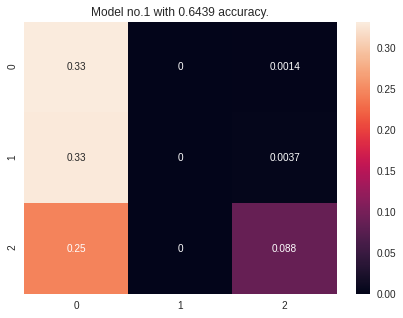

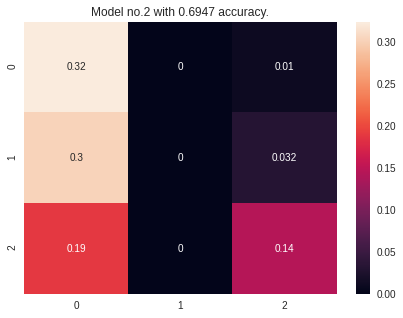

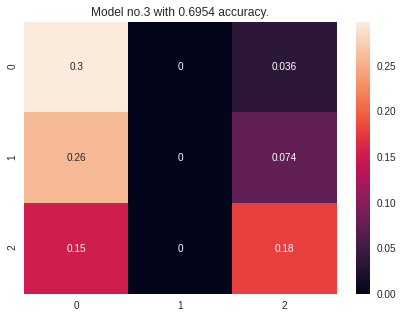

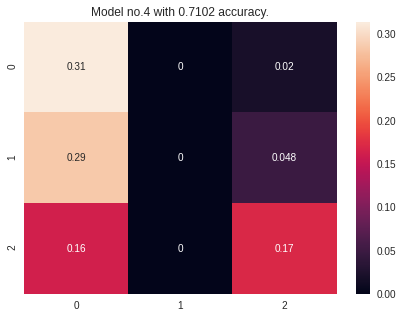

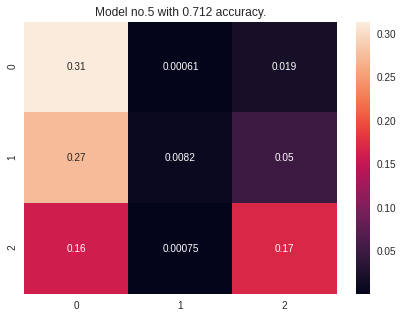

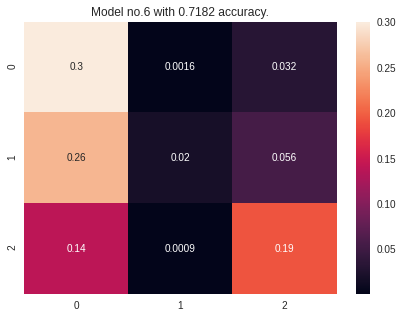

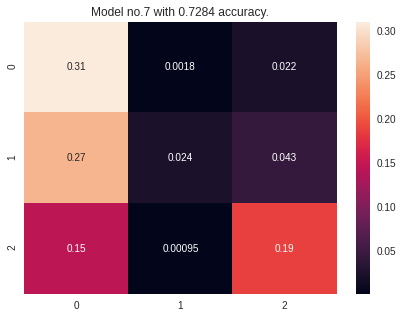

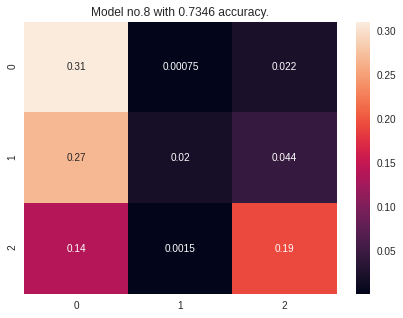

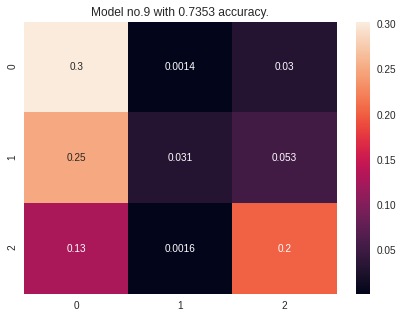

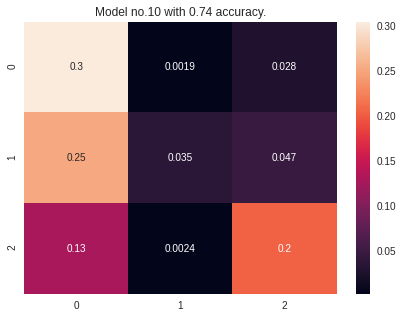

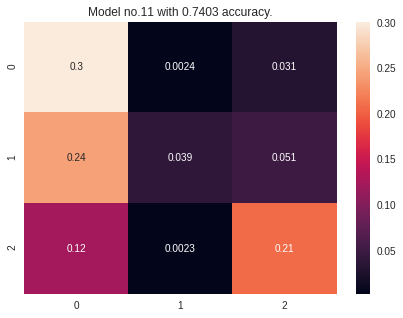

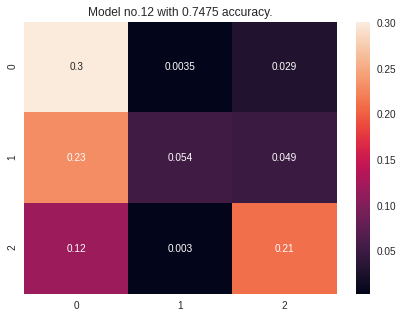

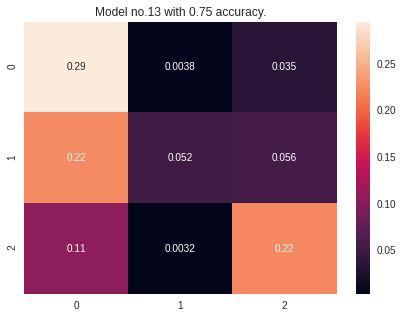

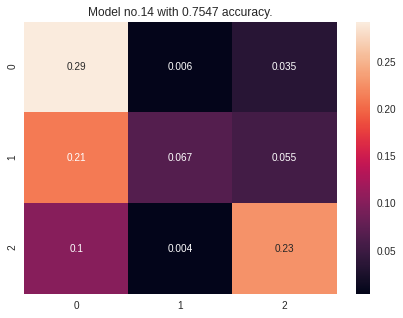

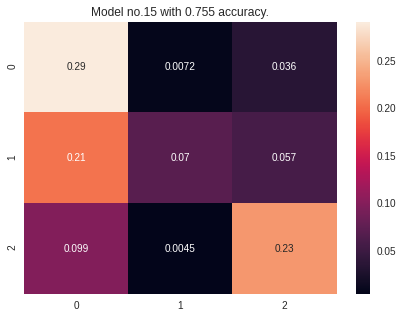

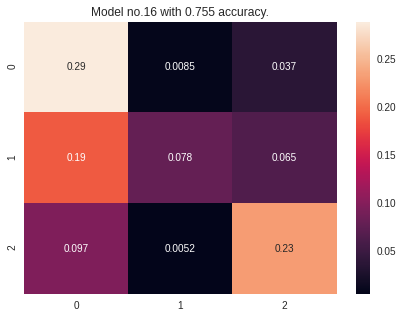

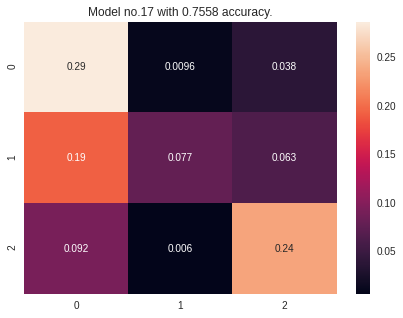

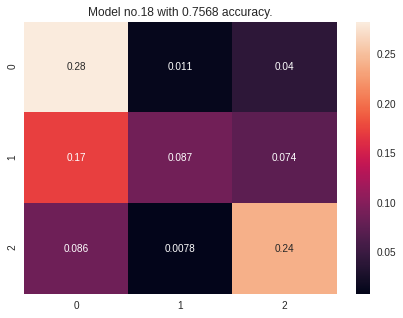

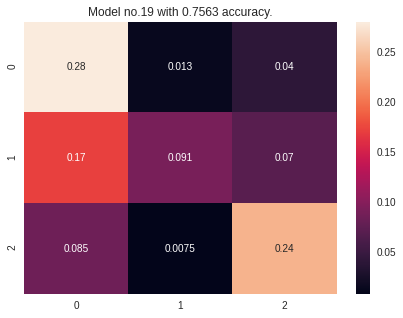

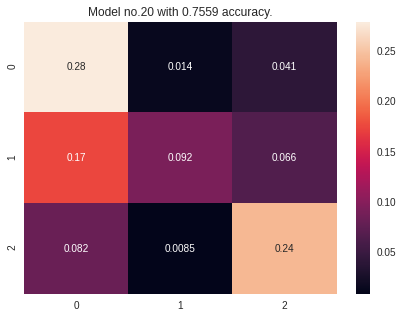

In [31]:
# setting empty lists to append scores 
treedepth_logLoss = []
treedepth_accuracyScores = []
iteration_count = 0

# I am checking up to a max depth of 20
for number in range(1, 21):
    iteration_count += 1
    # initialize, fit and predict using the model
    treedepthModel = DecisionTreeClassifier(max_depth=number, random_state=42)
    treedepthModel.fit(X_train_enc, y_train_enc)

    # predict with X test
    treedepth_probs = treedepthModel.predict_proba(X_test_enc)
    treedepth_preds = treedepthModel.predict(X_test_enc)
    
    # perform cross validation and scoring
    treedepth_logLoss_train = -(cross_val_score(treedepthModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())
    treedepth_logLoss_test = log_loss(y_test_enc, treedepth_probs)
        
    # append the scores to logloss and precision list
    treedepthlog_losses = (treedepth_logLoss_train, treedepth_logLoss_test)
    treedepth_logLoss.append(treedepthlog_losses)
    
    treedepth_accuracy_scores = accuracy_score(y_test_enc, treedepth_preds)    
    treedepth_accuracyScores.append(treedepth_accuracy_scores)
    
    # Make a confusion matrix for each iteration
    treedepthModel_conf = confusion_matrix(y_test_enc, treedepth_preds)
    
    # plot the matrix
    fig, ax = plt.subplots(figsize=(7, 5))
    
    sns.heatmap(treedepthModel_conf/np.sum(treedepthModel_conf), annot=True, ax=ax)    
    
    # for ease in understanding the matrix
    ax.set_title(f'Model no.{iteration_count} with {round(treedepth_accuracy_scores, 4)} accuracy.');

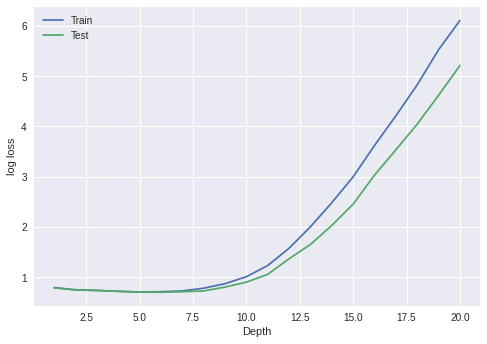

Log loss: 0.7005828195800908

Accuracy: 0.718155921167374


In [32]:
# transform treedepth_logLoss to an array
treedepth_logLoss = np.array(treedepth_logLoss)

# plot the graph of the above variations
# train log_loss
plt.plot(range(1, 21), treedepth_logLoss[:, 0], label='Train')
# test log_loss
plt.plot(range(1, 21), treedepth_logLoss[:, 1], label='Test')

# setting the graph labels
plt.xlabel('Depth')
plt.ylabel('log loss')
plt.legend()
plt.show()

# print the min test logloss
print('Log loss:', treedepth_logLoss[:, 1].min())
print()
print('Accuracy:', treedepth_accuracyScores[5])

> Note: The train log loss is generally higher than test log loss. Meaning the model is not overfitting, however there could be some degree of underfitting.

##### Conclusions:

At __depth = 6__ is when the test log loss is least. However, as the depth increases the precision of the predictions increases but at the cost of increase in log loss. For example, The model with the __best accuracy__ is the one with the __greatest depth__ parameter.

This could be because:

- The features that contain continuous variables. Their distribution isn't that smooth or favourable hence making it hard for the model to learn information about said features.

Because of this, I am no longer using log loss as a metric to measure the models, instead I am switching to accuracy as it is even simpler to interpret.

Also, I am turning to GridSearchCV that would be better for searching for the optimum hyperparameters.

#### 4.4.1.2. tree GridSearchCV

I am using grid search to quickly search through the parameters and find the best performing one.

I am including specific parameters for the gridsearch to search through. They are:

> `max_depth` - Short trees tend to underfit and vice versa. Previously I found out that the loss minimizing depth is 6, however, it does not produce the most accuracy. So I want to see which depth produce the optimum accuracy.

> `max_features` - Instead of always using all columns (the parameter default setting) when cosidering a split I want the model to automatically decide but not be fixated on all of them.

> `min_samples_leaf` - The smaller this value the more the model fits the training data.

> `min_samples_split` - The minimum samples a node should have for it to be splitable.

In [33]:
# make the parameter grid for grid searching
tree_paramGrid = {
    'max_depth': range(6, 21),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 11),
    'max_features': ['auto']
}

# instantiate the model
treeSearchModel = DecisionTreeClassifier(random_state=42)

# use GridSearchCV
tree_GS = GridSearchCV(treeSearchModel, tree_paramGrid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

# fit the gridsearcher
tree_GS.fit(X_train_enc, y_train_enc)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(6, 21), 'max_features': ['auto'],
                         'min_samples_leaf': range(1, 11),
                         'min_samples_split': range(2, 10)},
             return_train_score=True, scoring='accuracy')

In [34]:
# print out the best parameters
print(f'Best Parameters: {tree_GS.best_params_}')
print()
# check scoring in train data
print(f'Train: {tree_GS.best_score_}')
print()
# check scoring in test data
print(f'Test: {tree_GS.score(X_test_enc, y_test_enc)}')

Best Parameters: {'max_depth': 19, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 2}

Train: 0.7546530459698518

Test: 0.7547235625835708


##### Conclusions:

The best params for the model do not lead to any overfitting or underfitting as seen from the train and test scores. It is safe to conclude that these are the best results I have obtained this far from a tree classifier.

I will consider the best_params of the grid search as the __optimal parameters__ for a tree classifier for this problem.

### 4.4.2. K-nearest Neighbor Classifier

#### 4.4.2.1. weights

The default weights parameter setting is uniform meaning that all n_neighbors considered are given the same weight when classifying a point. 

However, I think that a neighbor should be given more weight when its closer in proximity to a point. That is why I am changing the parameter setting to distance.

In [35]:
# Instantiate and fit the model
knn_weightsModel = KNeighborsClassifier(n_jobs=-1, weights='distance')
knn_weightsModel.fit(X_train_enc, y_train_enc)

# Predict using test data
knnweights_probs = knn_weightsModel.predict_proba(X_test_enc)
knnweights_preds = knn_weightsModel.predict(X_test_enc)

# Perform cross-validation on train data and scoring on test data
knnweights_logLoss_train = -(cross_val_score(knn_weightsModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())
knnweights_logLoss_test = log_loss(y_test_enc, knnweights_probs)

In [36]:
# accuracy score
knnweights_acc = accuracy_score(y_test_enc, knnweights_preds)

# compare the scoring difference with baseline model
print('Baseline Model:', knnBaseline_acc)
print()
print('Weight parameter Model:', knnweights_acc)

Baseline Model: 0.7469333178303587

Weight parameter Model: 0.7480379047729783


##### Conclusion:

By changing the weights parameter to distance the model accuracy increases showing that this is a better KNN parameter setting for this problem.

#### 4.4.2.2. n_neighbors

<ipython-input-37-45e1ebe54b92>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(7, 5))


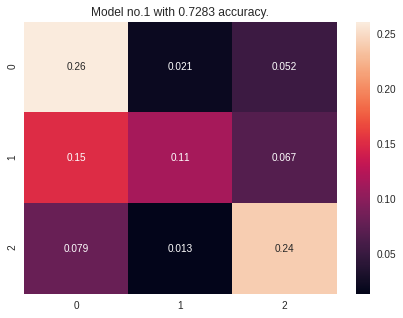

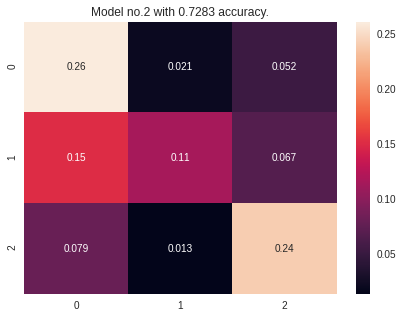

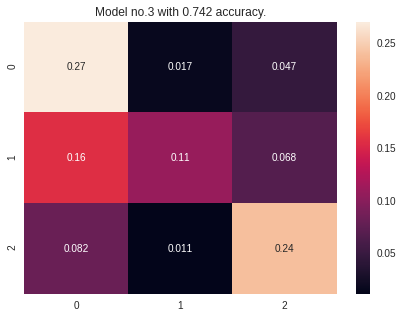

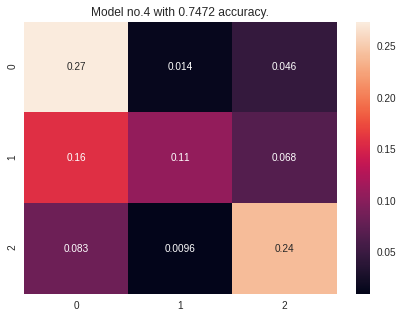

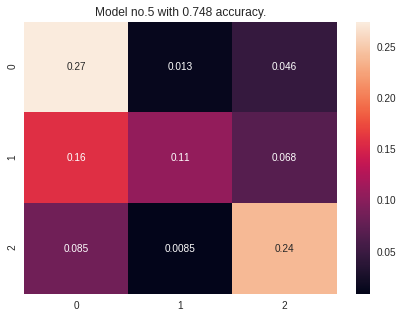

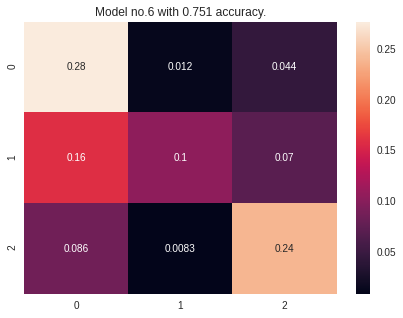

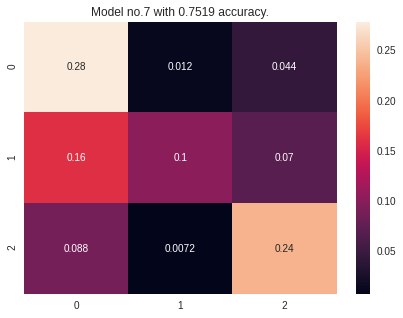

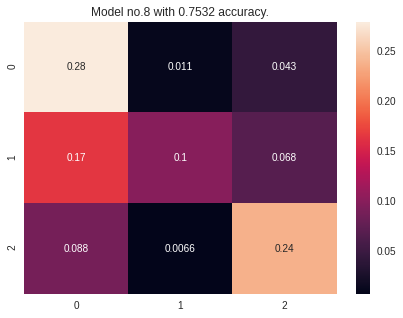

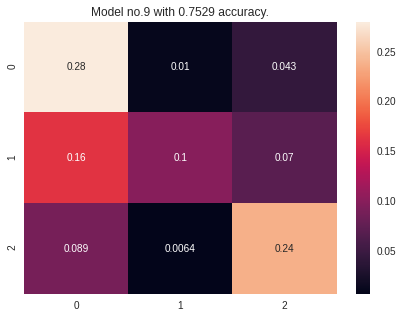

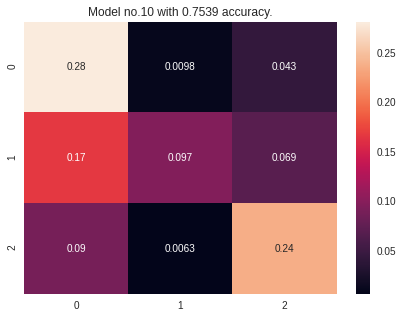

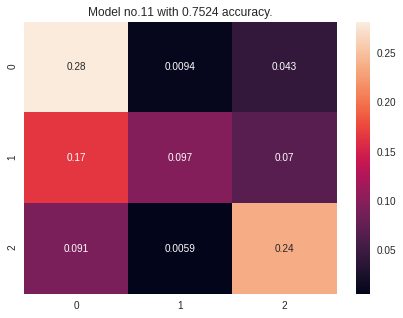

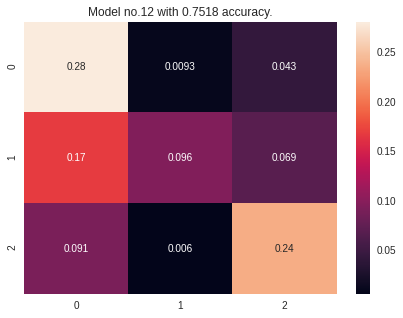

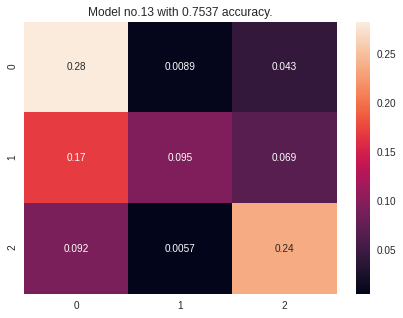

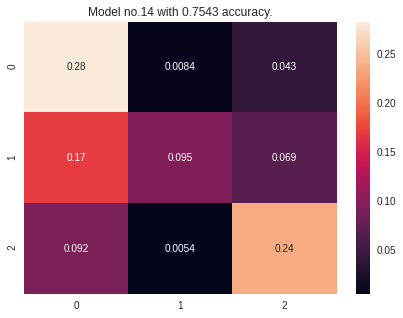

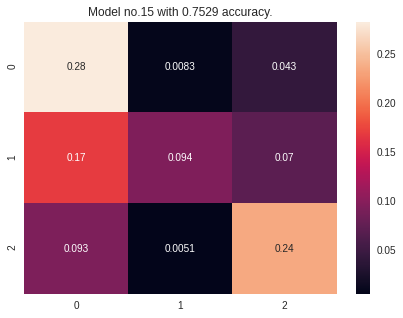

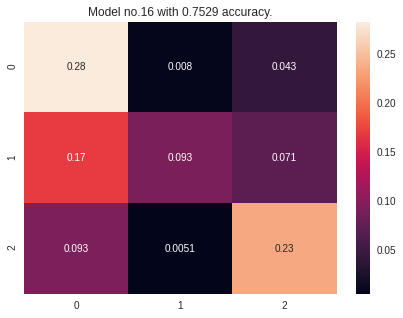

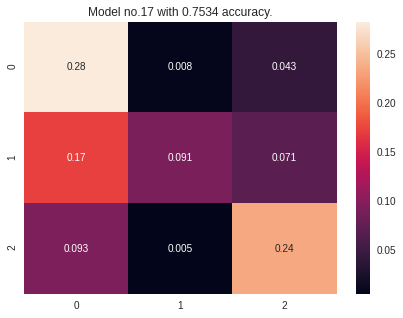

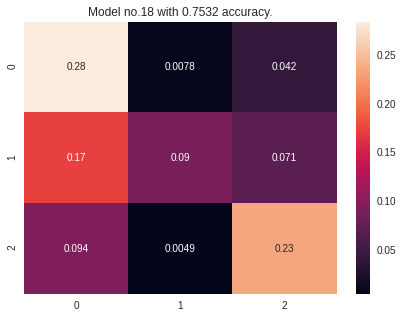

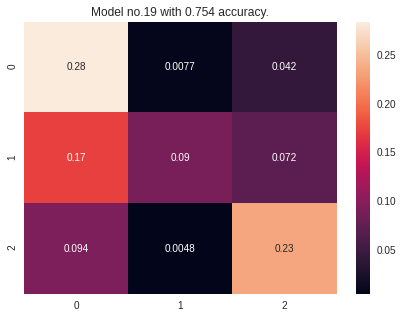

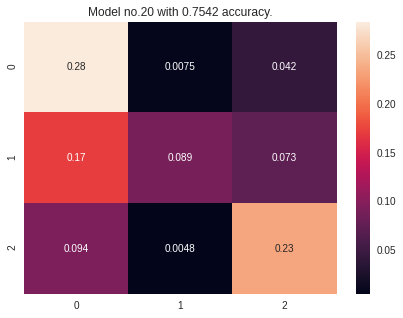

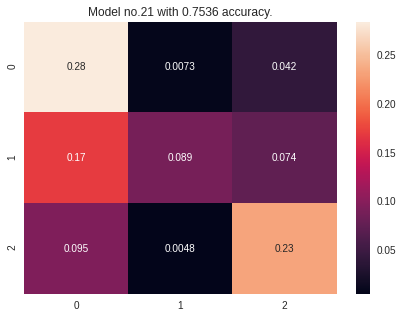

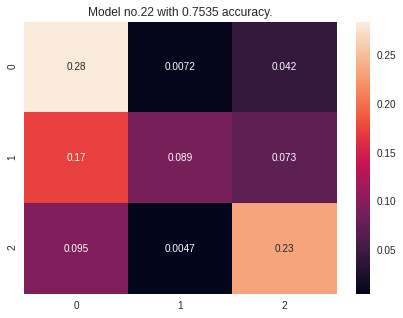

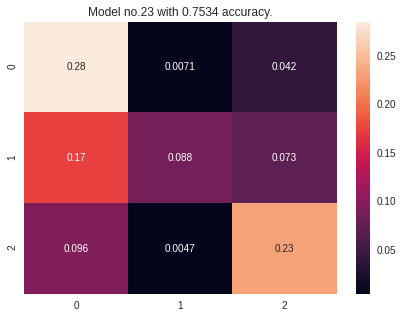

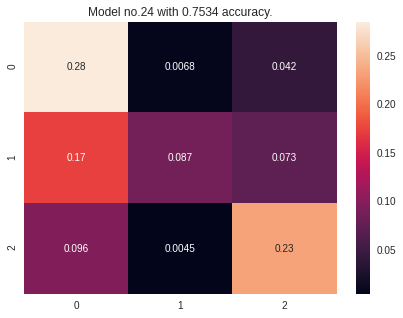

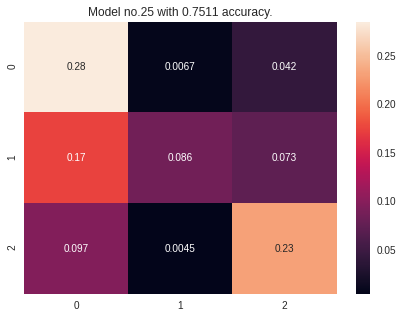

In [37]:
# making lists to append scores from iterative modelling
knnNeighbors_logLoss = []
knnNeighbors_accuracyScores = []
iteration_count_2 = 0

# Checking from 1 to 25 neighbors
for number in range(1, 26):
    iteration_count_2 += 1
    # initialize, fit and predict using the model
    knn_neighborsModel = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=number)
    knn_neighborsModel.fit(X_train_enc, y_train_enc)

    # predict with X test
    knnNeighbors_probs = knn_neighborsModel.predict_proba(X_test_enc)
    knnNeighbors_preds = knn_neighborsModel.predict(X_test_enc)
    
    # perform cross validation and scoring
    knnNeighbors_logLoss_train = -(cross_val_score(knn_neighborsModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())
    knnNeighbors_logLoss_test = log_loss(y_test_enc, knnNeighbors_probs)
        
    # append the scores to logloss and precision list
    knnNeighborslog_losses = (knnNeighbors_logLoss_train, knnNeighbors_logLoss_test)
    knnNeighbors_logLoss.append(knnNeighborslog_losses)
    
    knnNeighbors_accuracy_scores = accuracy_score(y_test_enc, knnNeighbors_preds)    
    knnNeighbors_accuracyScores.append(knnNeighbors_accuracy_scores)
    
    # Make a confusion matrix for each iteration
    knn_neighborsModel_conf = confusion_matrix(y_test_enc, knnNeighbors_preds)
    
    # plot the matrix
    fig, ax = plt.subplots(figsize=(7, 5))
    
    sns.heatmap(knn_neighborsModel_conf/np.sum(knn_neighborsModel_conf), annot=True, ax=ax)    
    
    # for ease in understanding the matrix
    ax.set_title(f'Model no.{iteration_count_2} with {round(knnNeighbors_accuracy_scores, 4)} accuracy.');

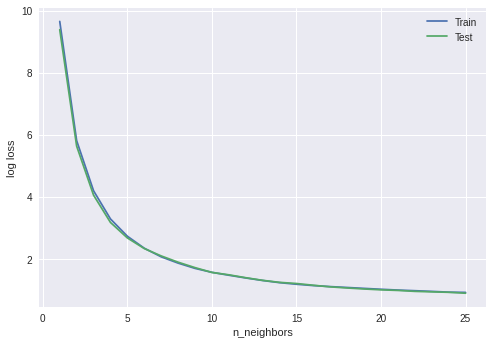

Log loss: 0.8917143195764935

Accuracy: 0.7511191209813383


In [38]:
# transform knnNeighbors_logLoss to an array
knnNeighbors_logLoss = np.array(knnNeighbors_logLoss)

# plot the graph of the above variations
# train log_loss
plt.plot(range(1, 26), knnNeighbors_logLoss[:, 0], label='Train')
# test log_loss
plt.plot(range(1, 26), knnNeighbors_logLoss[:, 1], label='Test')

# setting the graph labels
plt.xlabel('n_neighbors')
plt.ylabel('log loss')
plt.legend()
plt.show()

# print the min test logloss
print('Log loss:', knnNeighbors_logLoss[:, 1].min())
print()
print('Accuracy:', knnNeighbors_accuracyScores[-1])

In [39]:
# max accuracy score details
print(f'Maximum accuracy score of the iterated models is {np.array(knnNeighbors_accuracyScores).max()}.')
print()
print(f'The model maximizing accuracy has n_neighbors parameter as {knnNeighbors_accuracyScores.index(0.754258473344573) + 1}.')
print()
print(f'The corresponding log loss values for Train and Test for the max accuracy model are {knnNeighbors_logLoss[13]}.')


Maximum accuracy score of the iterated models is 0.754258473344573.

The model maximizing accuracy has n_neighbors parameter as 14.

The corresponding log loss values for Train and Test for the max accuracy model are [1.23180002 1.24110338].


##### Conclusions:

Once again the most accurate model does not minimize the log loss. 

And __once again__ I am picking the most accurate model because accuracy matters more here.

The optimum n_neighbors is:
    
    n_neighbors = 14

#### 4.4.2.3. leaf_size


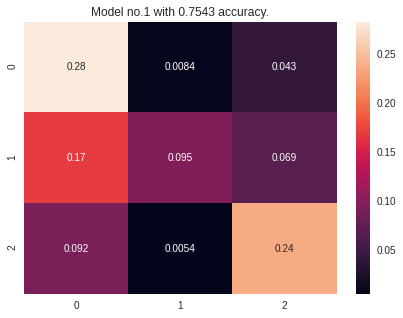

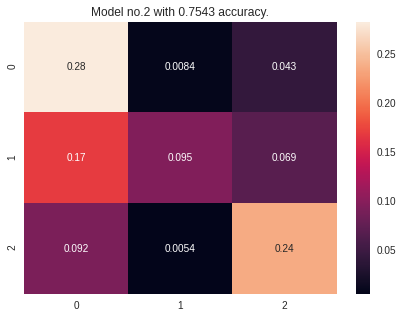

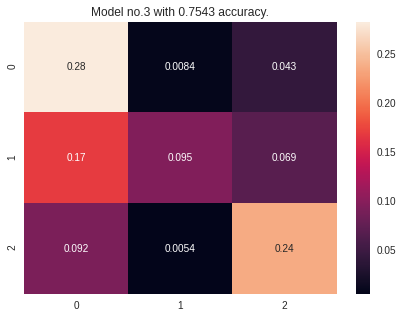

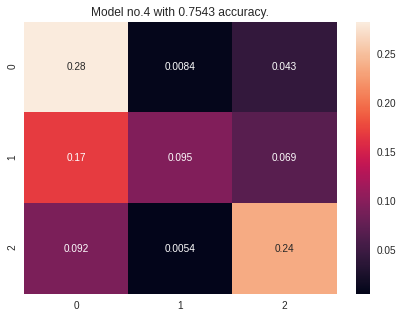

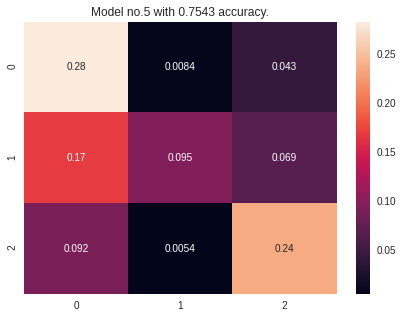

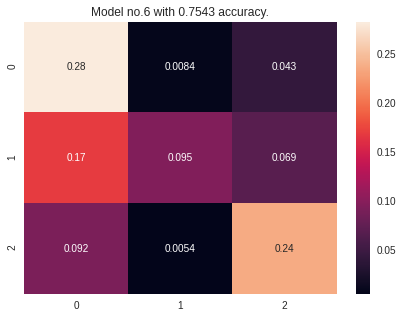

In [40]:
# making lists to append scores from iterative modelling
knnLeaf_logLoss = []
knnLeaf_accuracyScores = []
iteration_count_3 = 0

# default is 30 
# so I am mainly checking for 1, 10, 20, 40 and 50
leaf_sizes = [1, 10, 20, 30, 40, 50]

for leaf_sz in leaf_sizes:
    iteration_count_3 += 1
    # initialize, fit and predict using the model
    knn_leafModel = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=14 , leaf_size=leaf_sz)
    knn_leafModel.fit(X_train_enc, y_train_enc)

    # predict with X test
    knnLeaf_probs = knn_leafModel.predict_proba(X_test_enc)
    knnLeaf_preds = knn_leafModel.predict(X_test_enc)
    
    # perform cross validation and scoring
    knnLeaf_logLoss_train = -(cross_val_score(knn_leafModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())
    knnLeaf_logLoss_test = log_loss(y_test_enc, knnLeaf_probs)
        
    # append the scores to logloss and precision list
    knnLeaflog_losses = (knnLeaf_logLoss_train, knnLeaf_logLoss_test)
    knnLeaf_logLoss.append(knnLeaflog_losses)
    
    knnLeaf_accuracy_scores = accuracy_score(y_test_enc, knnLeaf_preds)    
    knnLeaf_accuracyScores.append(knnLeaf_accuracy_scores)
    
    # Make a confusion matrix for each iteration
    knn_leafModel_conf = confusion_matrix(y_test_enc, knnLeaf_preds)
    
    # plot the matrix
    fig, ax = plt.subplots(figsize=(7, 5))
    
    sns.heatmap(knn_leafModel_conf/np.sum(knn_leafModel_conf), annot=True, ax=ax)    
    
    # for ease in understanding the matrix
    ax.set_title(f'Model no.{iteration_count_3} with {round(knnLeaf_accuracy_scores, 4)} accuracy.');

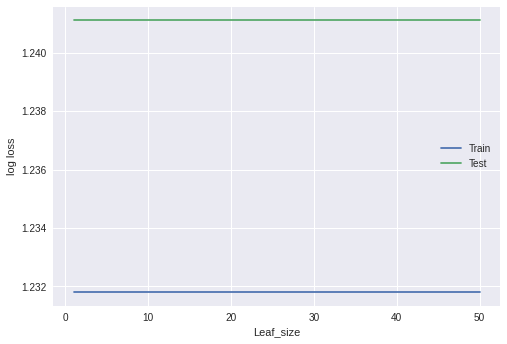

Log loss: 1.2411033765353663

Accuracy: 0.754258473344573


In [41]:
# transform knnNeighbors_logLoss to an array
knnLeaf_logLoss = np.array(knnLeaf_logLoss)

# plot the graph of the above variations
# train log_loss
plt.plot(leaf_sizes, knnLeaf_logLoss[:, 0], label='Train')
# test log_loss
plt.plot(leaf_sizes, knnLeaf_logLoss[:, 1], label='Test')

# setting the graph labels
plt.xlabel('Leaf_size')
plt.ylabel('log loss')
plt.legend()
plt.show()

# print the min test logloss
print('Log loss:', knnLeaf_logLoss[:, 1].min())
print()
print('Accuracy:', knnLeaf_accuracyScores[0])

##### Conclusions:

Leaf_size has no effect on the perfomance of a KNN model in this problem.

Therefore, the only KNN classifier parameters being tuned in this problem are:

    n_neighbors = 14 
    and
    weights = 'distance'
    

## 4.5. Random Forest Ensemble

I am going to use the best parameters for the tree model as the parameters for the random forest classifier.

In [42]:
# instantiate the random forest ensemble
randForest_clf = RandomForestClassifier(random_state=42, 
                                        n_estimators=100, 
                                        max_depth=19, 
                                        max_features='auto', 
                                        min_samples_leaf=6, 
                                        min_samples_split=2
                                       )

# fit it to train data
randForest_clf.fit(X_train_enc, y_train_enc)

RandomForestClassifier(max_depth=19, min_samples_leaf=6, random_state=42)

In [43]:
# make predictions with test data 
randForest_probs = randForest_clf.predict_proba(X_test_enc)
randForest_preds = randForest_clf.predict(X_test_enc)

# Perform scoring for the random forest model
randForest_logLoss_train = -(cross_val_score(randForest_clf, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())
randForest_logLoss_test = log_loss(y_test_enc, randForest_probs)

randForest_accuracy_scores = randForest_clf.score(X_test_enc, y_test_enc)

# print out the accuracy score
print(f'The Random Forest model has an accuracy test score of {randForest_accuracy_scores}')

The Random Forest model has an accuracy test score of 0.7940236032788791


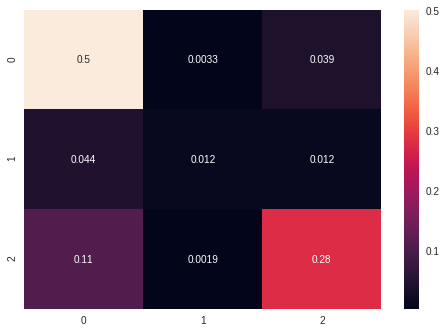

In [61]:
# make a confusion matrix for the forest classifier model
randForest_conf = confusion_matrix(y_test_enc, randForest_preds)

sns.heatmap(randForest_conf/np.sum(randForest_conf), annot=True);

### Conclusions: 

The random forest model has the __best accuracy__ out of all the models made. This is mainly attributed to the inherent advantages that it has over other modelling methods. For example: It trains multiple models and uses them to come to a decision and this kind of a model would obviously overpower the accuracy of a single model.

However, it's accuracy isn't too different from the accuracies of the optimal single models.

This begs the question, Is it worth it? Because the training and prediction time for the forest classifier is very long and it obviously takes more resources(RAM) when computing as compared to the single models .

The __tie breaker__ for the best model will be the one with the least log_loss.

## 5. Model Selection

The selection is to be done among the best models so far including the random forest ensemble model.

The tie breaker for the best model will be log_loss.

It's because the models have very close accuracies except for randForest_clf which has the best accuracy but takes very long to compute.

## 5.1. Tree classifier

In [44]:
# instantiate the final tree classifier
tree_finalModel = DecisionTreeClassifier(random_state=42, 
                                         max_depth=19, 
                                         max_features='auto', 
                                         min_samples_leaf=6, 
                                         min_samples_split=2
                                        )

# fit the classifier
tree_finalModel.fit(X_train_enc, y_train_enc)

DecisionTreeClassifier(max_depth=19, max_features='auto', min_samples_leaf=6,
                       random_state=42)

In [56]:
# make predictions with test data 
treeFinal_probs = tree_finalModel.predict_proba(X_test_enc)
treeFinal_preds = tree_finalModel.predict(X_test_enc)

# Perform scoring for the final tree classifier
treeFinal_logLoss_train = -(cross_val_score(tree_finalModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())
treeFinal_logLoss_test = log_loss(y_test_enc, treeFinal_probs)

treeFinal_accuracy_scores = tree_finalModel.score(X_test_enc, y_test_enc)

# print out the accuracy score
print(f'The final tree model has an accuracy test score of {treeFinal_accuracy_scores}')

The final tree model has an accuracy test score of 0.7547235625835708


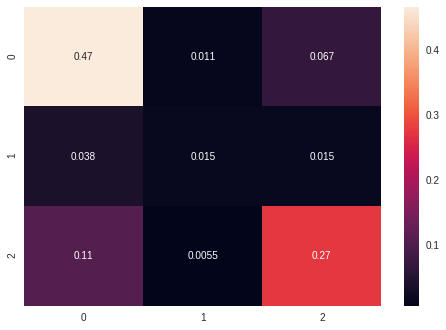

In [58]:
# make a confusion matrix for the final tree model
treeFinal_conf = confusion_matrix(y_test_enc, treeFinal_preds)

sns.heatmap(treeFinal_conf/np.sum(treeFinal_conf), annot=True);

## 5.2. KNN classifier

In [59]:
# instantiate the final tree classifier
knn_finalModel = KNeighborsClassifier(weights='distance', n_neighbors=14)

# fit the classifier
knn_finalModel.fit(X_train_enc, y_train_enc)

# make predictions with test data 
knnFinal_probs = knn_finalModel.predict_proba(X_test_enc)
knnFinal_preds = knn_finalModel.predict(X_test_enc)

In [47]:
# Perform scoring for the final tree classifier
knnFinal_logLoss_train = -(cross_val_score(knn_finalModel, X_train_enc, y_train_enc, scoring='neg_log_loss', cv=3).mean())
knnFinal_logLoss_test = log_loss(y_test_enc, knnFinal_probs)

knnFinal_accuracy_scores = knn_finalModel.score(X_test_enc, y_test_enc)

# print out the accuracy score
print(f'The final knn model has an accuracy test score of {knnFinal_accuracy_scores}')

The final knn model has an accuracy test score of 0.754258473344573


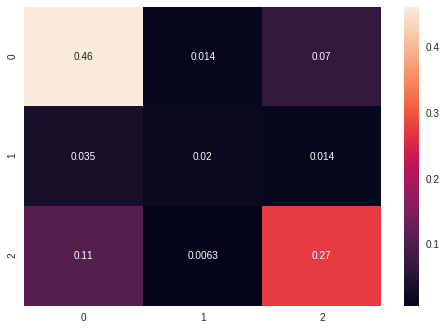

In [60]:
# make a confusion matrix for the final knn model
knnFinal_conf = confusion_matrix(y_test_enc, knnFinal_preds)

sns.heatmap(knnFinal_conf/np.sum(knnFinal_conf), annot=True);

## 5.3. Selection

In [48]:
# compare the log loss scores of the optimal models
print(f'The log loss values for the Random Forest classifier are {randForest_logLoss_train, randForest_logLoss_test}.')
print()
print(f'The log loss values for the Decision Tree classifier are {treeFinal_logLoss_train, treeFinal_logLoss_test}.')
print()
print(f'The log loss values for the KNN classifier are {knnFinal_logLoss_train, knnFinal_logLoss_test}.')

The log loss values for the Random Forest classifier are (0.532059295631319, 0.5140737976308284).

The log loss values for the Decision Tree classifier are (1.947243734723342, 1.7922203267935828).

The log loss values for the KNN classifier are (1.2318000170888668, 1.2411033765353663).


### Conclusions:

Between KNN and tree classifier, KNN performs better than the latter.

However, the forest ensemble model performs better than both of the single classifiers.

# 6. Model Evaluation

The best model is the random forest classifier. It has the best accuracy and log loss, and although it takes long to train, it is not too long to make it cumbersome thus it is the best model.

In [51]:
# SINCE I had already made the model before, Ill just call it plus the metrics
# set the final model
final_Model = randForest_clf

# set the predictions with test data
finalModel_preds = final_Model.predict(X_test_enc)

# make the scoring variables
# train data
finalModel_accuracy_scores_train = randForest_clf.score(X_train_enc, y_train_enc)
finalModel_logLoss_train =  randForest_logLoss_train

# test
finalModel_accuracy_scores_test = randForest_clf.score(X_test_enc, y_test_enc)
finalModel_logLoss_test =  randForest_logLoss_test

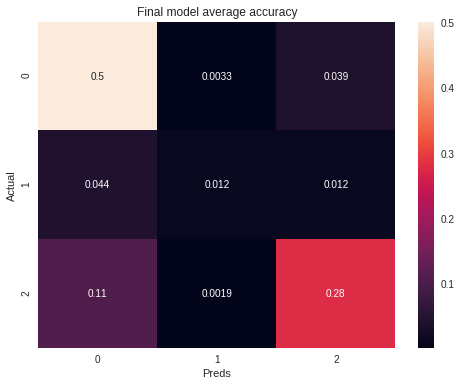

In [89]:
# make a confusion matrix showing the avarage accuracy for the final model
finalModel_conf = confusion_matrix(y_test_enc, finalModel_preds)

plt.figure(figsize=(8, 6))

sns.heatmap(finalModel_conf/np.sum(finalModel_conf), annot=True)

plt.title('Final model average accuracy')
plt.xlabel('Preds')
plt.ylabel('Actual')
plt.savefig('/home/nick/Documents/Flatiron/Phase 3/Water_wells_Project/Images/final_model_av_accuracy.png');

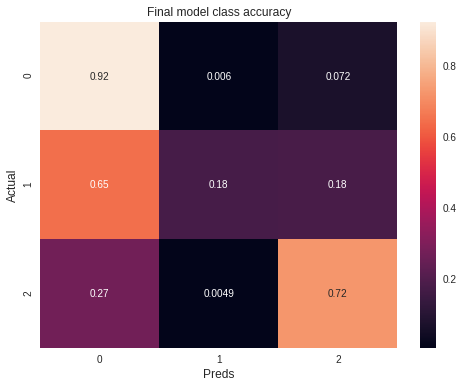

In [88]:
# make a confusion matrix showing accuracy per class for the final model
finalModel_conf = confusion_matrix(y_test_enc, finalModel_preds, normalize='true')

plt.figure(figsize=(8, 6))

sns.heatmap(finalModel_conf, annot=True)

plt.title('Final model class accuracy')
plt.xlabel('Preds', fontdict={'size': 12})
plt.ylabel('Actual', fontdict={'size': 12})
plt.savefig('/home/nick/Documents/Flatiron/Phase 3/Water_wells_Project/Images/final_model_class_accuracy.png');

In [54]:
# print out the model scores
print('The accuracy scores for the final model on Train data is {}, while on the Test data it is {}.\n'
      .format(round(finalModel_accuracy_scores_train, 4), round(finalModel_accuracy_scores_test, 4))
     )

print('The log loss scores for the final model are {} on Train data and {} on Test data.'
     .format(round(finalModel_logLoss_train, 6), round(finalModel_logLoss_test, 6)))

The accuracy scores for the final model on Train data is 0.8376, while on the Test data it is 0.794.

The log loss scores for the final model are 0.532059 on Train data and 0.514074 on Test data.


I am using accuracy score for measuring the performance of the model because it is easy to interpret, the most appropriate score and also it turns out that all scoring metrics have the same results so they can be used interchangeably.

The final model performance is satisfactory. It is not overfitting or underfitting.

> The average accuracy for the final model is __~79.4%__.

However, when breaking down the accuracy of prediction for the different classes I notice that the accuracies vary such as:

    'Functioning' accuracy = ~92%
    'Functioning needing repairs' accuracy= ~18%
    
> The accuracy for determining waterpoints that are functional needing repairs is badly off than the others. This can be because of the imbalance of class proportions where this class has the least proportion by far with only __~7%__ of the data being waterpoints that need repair. Meaning that waterpoints are majorly functional or not-functional and with regards to that the model has satisfactory performance.

    'Not-functional' accuracy = ~72%
    
> Also because most waterpoints in Tanzania are functional, The model mostly classifies waterpoints as being functional as seen in the confusion matrix where the first column has the most of the data.


## Recommendations:

With the model having an accuracy for __functional__ waterpoints as __~92%__ and accuracy for __non-functional__ waterpoints as __~72%__ I deem it good enough for use. This is because these two classes are the main focus for the Tanzanian government in the subject of waterpoints in the country because the number of waterpoints that fall in between are minimal.

However, there are some things that stood out during the analysis:

- A couple of features e.g funder and installer that could have been substantially useful for modelling were dropped earlier on. Because they had a lot of errors in the entries.

> My recommendation about this matter would be for the agents who fill in the data in the database to take extra care in what and how they record the data. Or better yet, to have a stipulated format on filling in data. That would make the data more viable for drawing inferences and building models.

- Also the language in some features is mixed thereby causing the application of said features to the model to be difficult.

> My recommendation is that the language used when filling waterpoint information should be uniform to ease the use of such data in data analysis.

- Waterpoints should not be built with extraction methods such as `other` because they have a high fail rate of ~80% signifying that they aren't good for waterpoints.